In [1]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from utils import *
%matplotlib inline
from audio_embed import utilities
plt.style.use('dark_background')

n_fft = 2048
hop_length = 256
sr = None

source_files = ['/mm1/seetharaman/scaper_data/speaker_separation/si_tr_s/012/012a0103.wav', 
                '/mm1/seetharaman/scaper_data/speaker_separation/si_tr_s/013/013c020w.wav']
sources = []
parameters = []
for source_file in source_files:
    source, sr = librosa.load(source_file, sr=sr, mono=False)
    utilities.audio(source, sr, ext='.wav')
    sources.append(source)

length = min(x.shape[0] for x in sources)
sources = [s[:length] for s in sources]
delay_one = 40
delay_two = 20
attn_one = .25
attn_two = 1 - attn_one

mix = np.zeros((2, length+delay_one+delay_two))
mix[0, delay_two:-delay_one] = attn_one*sources[0]
mix[1, delay_one:-delay_two] = attn_two*sources[0]

mix[1, delay_one:-delay_two] += attn_one*sources[1]
mix[0, delay_two:-delay_one] += attn_two*sources[1]

#mix, sr = librosa.load('/mm1/seetharaman/scaper_data/music_separation/test/mixture/Al James - Schoolboy Facination - mixture.wav', 
#                   sr=None, mono=False, duration=15, offset=45)

utilities.audio(mix, sr, ext='.mp3')


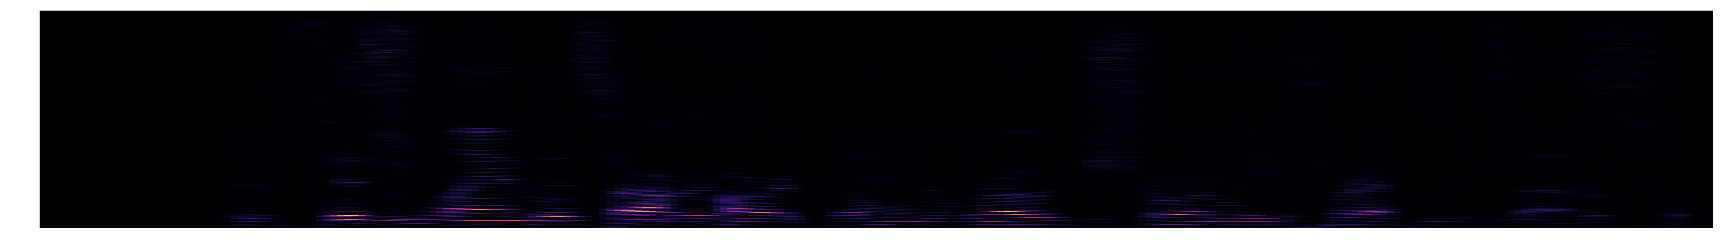

In [2]:
def transform(data, n_fft, hop_length):
    n = len(data)
    data = librosa.util.fix_length(data, n + n_fft // 2)
    stft = librosa.stft(data, n_fft=n_fft, hop_length=hop_length).T
    log_spec = librosa.amplitude_to_db(np.abs(stft), ref=np.max)
    return log_spec, stft

mix_stft= []

for ch in range(mix.shape[0]):
    _mix_log_magnitude, _mix_stft = transform(mix[ch], n_fft, hop_length)
    mix_stft.append(_mix_stft)
    
mix_stft = np.stack(mix_stft, axis=-1)

plt.figure(figsize=(30, 4))
plt.imshow(np.abs(mix_stft[:, :, 0].T), aspect='auto', origin='lower', cmap='magma')
plt.show()

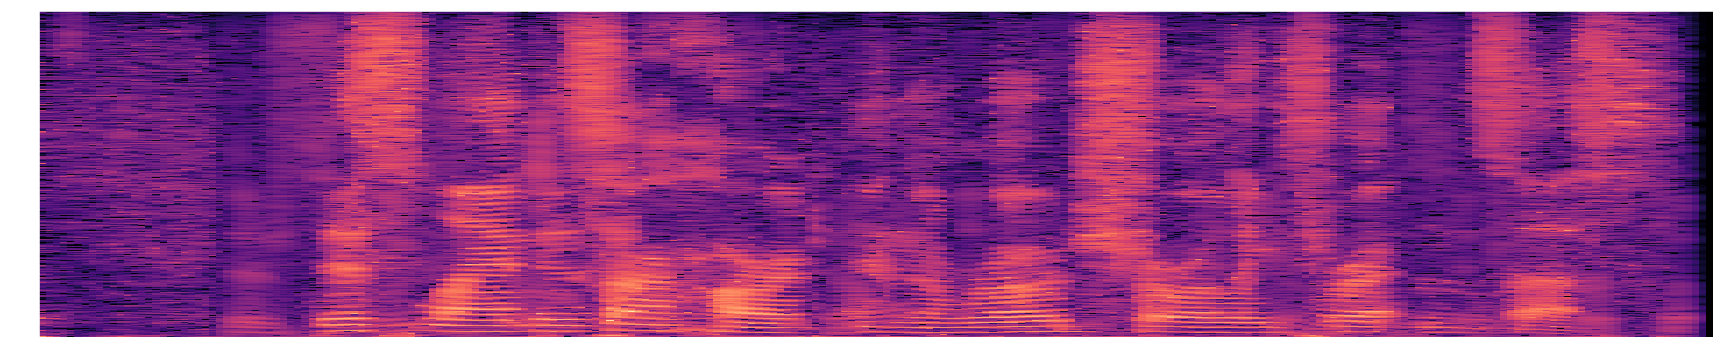

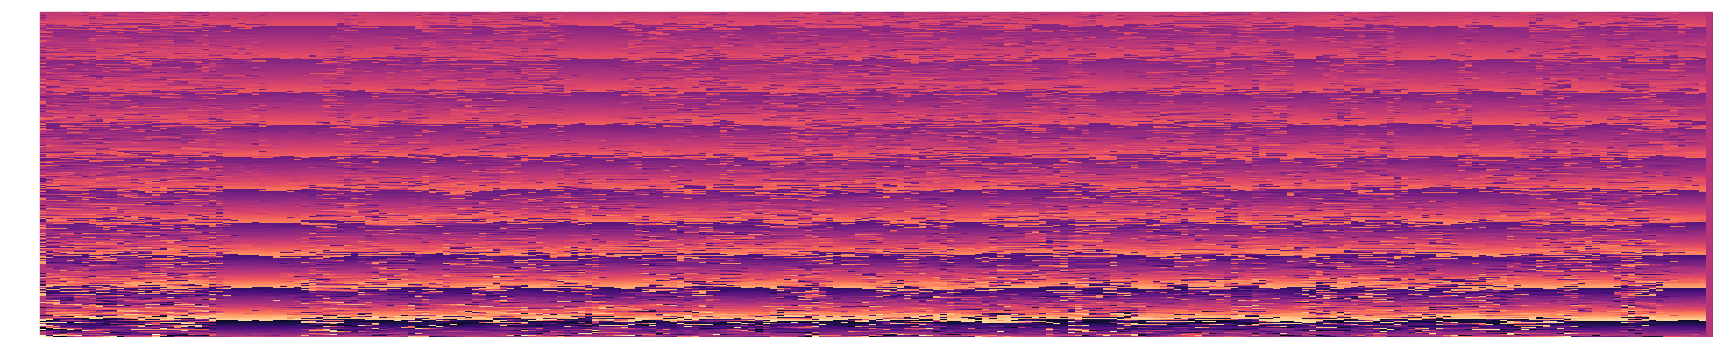

In [3]:
interlevel_difference = np.abs((mix_stft[:, :, 0] + 1e-8)**2 / (mix_stft[:, :, 1] + 1e-8))**2
interlevel_difference = 10*np.log10(interlevel_difference + 1e-8)
plt.figure(figsize=(30, 6))
plt.imshow(interlevel_difference.T, aspect='auto', origin='lower', cmap='magma')
plt.show()

frequencies = np.expand_dims((2 * np.pi * librosa.core.fft_frequencies(sr=sr, n_fft=n_fft)) / float(sr), axis=0)
interphase_difference = np.angle(mix_stft[:, :, 0] * np.conj(mix_stft[:, :, 1])) / (frequencies + 1.0)
plt.figure(figsize=(30, 6))
plt.imshow(interphase_difference.T, aspect='auto', origin='lower', cmap='magma')
plt.show()

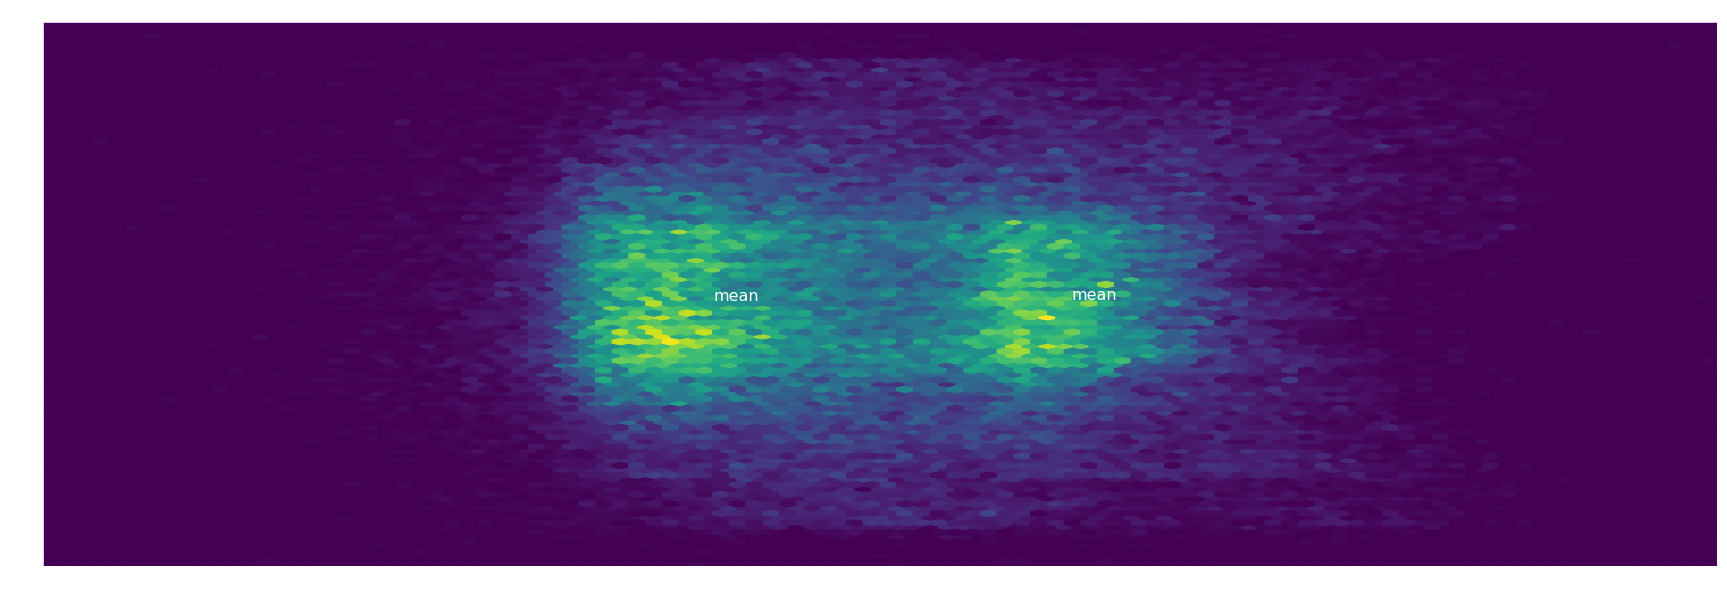

In [6]:
weights = np.mean(20*np.log10(np.abs(mix_stft) + 1e-8), axis=-1).flatten()
weights -= weights.min()
weights /= weights.max()

features = np.vstack([interlevel_difference.flatten(), interphase_difference.flatten()]).T
fig = plt.figure(figsize=(30, 10))
subplot = 121
ax = fig.add_subplot(111)

project_embeddings(features[weights>.75], num_dimensions=2, fig=fig, ax=ax, bins=None, gridsize=100)
for i in range(means.shape[-1]):
    x = means[:, i][0]
    plt.annotate('mean', xy=x, size=16)

plt.show()

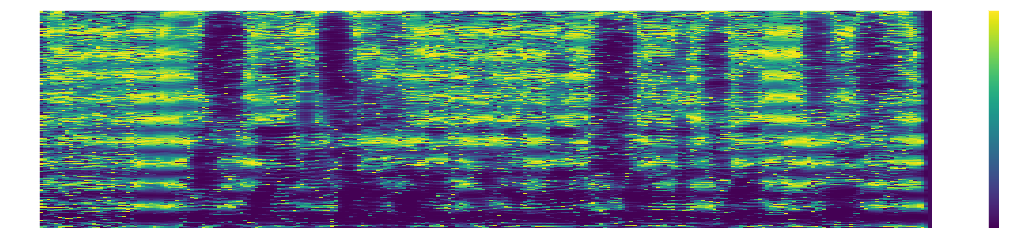

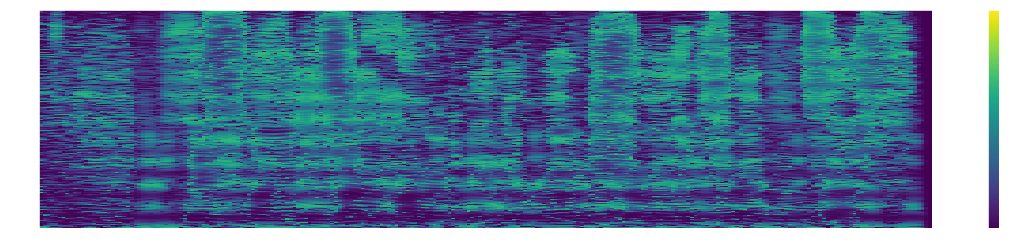

In [17]:
from networks.clustering import GMM, KMeans
import torch

device = torch.device('cuda')
data = torch.from_numpy(features).to(device).unsqueeze(0).float()
w = torch.from_numpy((weights > 0.2).astype(float)).to(device).unsqueeze(0).float()
clusterer = KMeans(n_clusters=2, n_iterations=20, alpha=1.0).to(device)
clusterer = GMM(n_clusters=2, n_iterations=20).to(device)

output = clusterer(data, weights=w)
if len(output[-1]) > 2:
    output = [output[0]] + [x for x in output[1]]
    assignments, means, var, pi = [x.cpu().data.numpy() for x in output]
else:
    assignments, means = [x.cpu().data.numpy() for x in output]
#assignments[:,  :] = 0
assignments = assignments.reshape(mix_stft.shape[:-1] + (-1,))


for i in range(assignments.shape[-1]):
    plt.figure(figsize=(20, 4))
    plt.imshow(assignments[:, :, i].T, aspect='auto', origin='lower', vmin=0.0, vmax=1.0)
    plt.colorbar()
    plt.show()

In [18]:
def mask_mixture(source_mask, mix):
    n = len(mix)
    mix = librosa.util.fix_length(mix, n + n_fft // 2)
    mix_stft = librosa.stft(mix, n_fft=n_fft, hop_length=hop_length)
    masked_mix = mix_stft * source_mask
    source = librosa.istft(masked_mix, hop_length=hop_length, length=n)
    return source

for i in range(assignments.shape[-1]):
    mask = assignments[:, :, i].T
    source = np.vstack([mask_mixture(mask, mix[i]) for i in range(mix.shape[0])])
    utilities.audio(source, sr)

/homes/seetharaman/anaconda2/envs/countnet/lib/python3.6/site-packages/librosa/util/utils.py:1725: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(x.dtype, float) or np.issubdtype(x.dtype, complex):


/homes/seetharaman/anaconda2/envs/countnet/lib/python3.6/site-packages/librosa/util/utils.py:1725: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(x.dtype, float) or np.issubdtype(x.dtype, complex):
